In [1]:
import numpy as np
import torch
import pyro.optim
import pyro
import pyro.distributions as dst
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def indepedentBivariate(D,N,loc=None,scale=None):
    with pyro.plate('D', D):
        if loc is None:
            loc = pyro.sample('loc', dst.Normal(torch.zeros(D),torch.ones(D)))
        if scale is None:
            scale = pyro.sample('scale', dst.LogNormal(torch.zeros(D),torch.ones(D)))
        with pyro.plate('N', N):
            obs = pyro.sample('obs', dst.Normal(loc,scale))
    return loc,scale,obs

tensor([-0.1126,  1.4610])
tensor([1.8361, 0.6921])


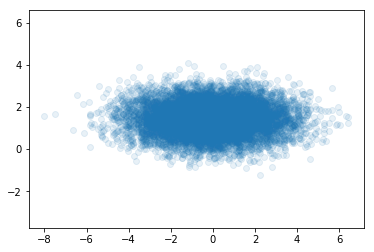

In [3]:
N = 10000
D = 2
loc,scale,obs = indepedentBivariate(D,N)
print(loc)
print(scale)
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

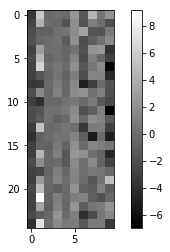

In [4]:
imN = 25
imD = 10
imloc,imscale,imobs = indepedentBivariate(imD,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [5]:
def factorBivariate(loc,scale,D,K,N,cov_factor=None):
    if cov_factor is None:
        with pyro.plate('D', D):
            with pyro.plate('K', K):
                cov_factor = pyro.sample('cov_factor', dst.Normal(0,1))
    with pyro.plate('N', N):
        obs = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor.transpose(0,1), cov_diag=scale))
    return cov_factor,obs

tensor([[ 2.4233, -0.1875],
        [-0.1875,  0.8654]])


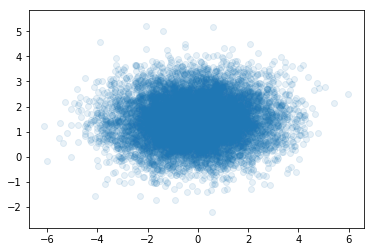

In [6]:
K = 2
N = 10000
D = 2
cov_factor,obs = factorBivariate(loc,scale,D,K,N)
print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

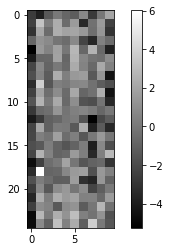

In [7]:
imN = 25
imD = 10
imK = 2
imcov_factor,imobs = factorBivariate(imloc,imscale,imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [8]:
def mixtureDiagGaussianSharedCovariance(D,K,N):
    with pyro.plate('D', D):
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(0.,1.))
        with pyro.plate('K', K):
            locs = pyro.sample('locs', dst.LogNormal(0.,1.))
        locs = locs*3
    with pyro.plate('N', N):
        obs = pyro.sample('obs', dst.MixtureOfDiagNormalsSharedCovariance(locs = locs, coord_scale = coord_scale, component_logits = torch.ones(K)))
    return locs,coord_scale,obs

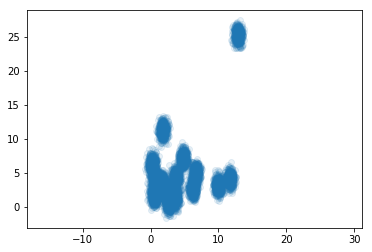

In [9]:
N = 10000
D = 2
K = 15
locs,coord_scale,obs = mixtureDiagGaussianSharedCovariance(D,K,N)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

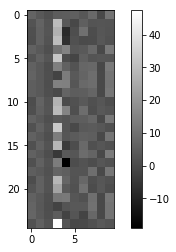

In [10]:
imN = 25
imD = 10
imK = 2
_,_,imobs = mixtureDiagGaussianSharedCovariance(imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [11]:
def mixtureGaussianSharedCovariance(D,K,N):
    weights = pyro.sample('weights', dst.Dirichlet(0.5 * torch.ones(K)))
    locs = torch.empty((D,K))
    for k in range(K):
        loc,scale,obs = indepedentBivariate(D,N)
        locs[:,k] = loc*10*D**2
    print(locs)
    cov_factor,obs = factorBivariate(loc,scale,D,K,N)
    old_scale = scale
    scale = torch.matmul(cov_factor.transpose(0,1),cov_factor)+torch.diag(scale)
    obs = torch.empty((N,D))
    for n in range(N):
        assignment = pyro.sample('assignment', dst.Categorical(weights))
        _,obs[n] = factorBivariate(locs[:,assignment],old_scale,D,K,1,cov_factor=scale)
    return locs,obs

tensor([[ 64.7993,  63.7777,  57.9447,  10.0191,  43.8757,   7.0647,  25.7725,
          44.9492,  27.0286, -34.0887,   8.8191, -73.5330,  28.5262, -48.1204,
         -14.7665],
        [ 54.7335,  38.3194,   3.7306,  -3.6803, -12.5523, -48.1184,  18.0253,
           4.7692,  26.1517,   3.8389,  35.2504, -18.6176,  72.6017,  23.7678,
          -9.7052]])


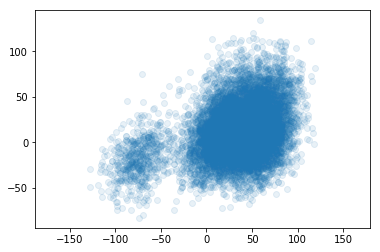

In [12]:
N = 10000
D = 2
K = 15
locs,obs = mixtureGaussianSharedCovariance(D,K,N)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

tensor([[ 1203.3101,   710.1224],
        [ -541.4339,  -488.5628],
        [ -420.8692, -2056.0034],
        [ -449.5488,  2083.8430],
        [  924.6687,   718.8518],
        [ -775.9530,  1447.4495],
        [  -66.7484, -2938.7661],
        [  440.5239,   617.0690],
        [-1622.7617,   903.8958],
        [  884.8609, -2088.2168]])


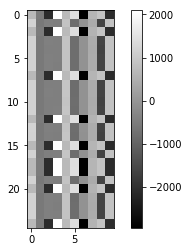

In [13]:
imN = 25
imD = 10
imK = 2
_,imobs = mixtureGaussianSharedCovariance(imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [14]:
def mixtureGaussianScaledSharedCovariance(D,K,N):
    weights = pyro.sample('weights', dst.Dirichlet(0.5 * torch.ones(K)))
    locs = torch.empty((D,K))
    for k in range(K):
        component_scale = pyro.sample('component_scale', dst.LogNormal(torch.zeros(K),1.))
        loc,scale,obs = indepedentBivariate(D,N)
        locs[:,k] = loc*10*D**2
    cov_factor,obs = factorBivariate(loc,scale,D,K,N)
    old_scale = scale
    scale = torch.matmul(cov_factor.transpose(0,1),cov_factor)+torch.diag(scale)
    obs = torch.empty((N,D))
    for n in range(N):
        assignment = pyro.sample('assignment', dst.Categorical(weights))
        _,obs[n] = factorBivariate(locs[:,assignment],old_scale,D,K,1,cov_factor=scale*component_scale[assignment])
    return locs,obs

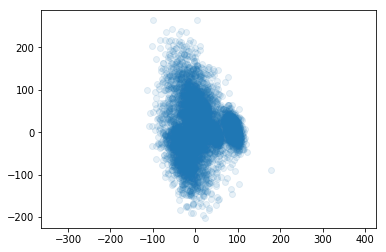

In [15]:
K = 15
locs,obs = mixtureGaussianScaledSharedCovariance(D,K,N)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

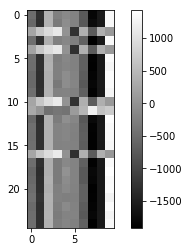

In [16]:
imN = 25
imD = 10
imK = 3
_,imobs = mixtureGaussianScaledSharedCovariance(imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [17]:
def mixtureGaussianScaledIdentityCovariance(D,K,N):
    weights = pyro.sample('weights', dst.Dirichlet(0.5 * torch.ones(K)))
    print(weights)
    locs = torch.empty((D,K))
    scales = torch.empty(K)
    for k in range(K):
        loc,scale,obs = indepedentBivariate(D,N)
        locs[:,k] = loc
        scales[k] = scale[0]
    locs *= 10
    obs = torch.empty((N,D))
    for n in range(N):
        assignment = pyro.sample('assignment', dst.Categorical(weights))
        _,_,obs[n] = indepedentBivariate(D,1,locs[:,assignment],scales[assignment])
    return locs,obs

tensor([5.7212e-02, 3.1612e-01, 1.3897e-02, 2.3642e-02, 2.3135e-01, 9.4065e-05,
        4.0937e-03, 2.3714e-02, 7.1458e-03, 3.0491e-02, 9.6535e-04, 4.1188e-02,
        1.7766e-01, 7.2340e-02, 8.6277e-05])
tensor([[ 13.0360,  -3.3965,   3.3950, -19.6680,  -4.2283,  -2.4981, -11.7528,
           2.5036,  -5.3149,  -5.5773,  -6.5938,   5.8719,  15.7093,  -6.8302,
          -0.1869],
        [  8.2453,   1.8802,  -0.1092,  -1.4088,  11.6959, -14.6463,  -6.3854,
          -7.1692,  -5.2309,  -8.8057,  -8.9167,  16.7790, -10.5969,  -4.1875,
          -7.8412]])
tensor([0.3188, 0.7297])


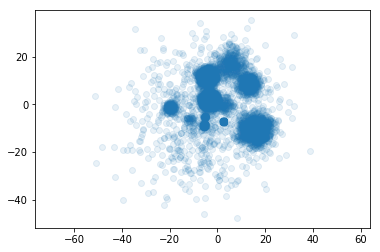

In [18]:
K = 15
locs,obs = mixtureGaussianScaledIdentityCovariance(D,K,N)
print(locs)
print(coord_scale)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

tensor([0.3167, 0.4891, 0.1943])


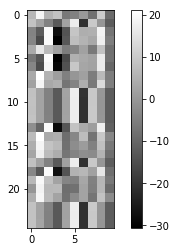

In [20]:
imN = 25
imD = 10
imK = 3
_,imobs = mixtureGaussianScaledIdentityCovariance(imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [21]:
def mixtureGaussianDiagCovariance(D,K,N):
    weights = pyro.sample('weights', dst.Dirichlet(0.5 * torch.ones(K)))
    locs = torch.empty((D,K))
    scales = torch.empty((D,K))
    for k in range(K):
        locs[:,k],scales[:,k],obs = indepedentBivariate(D,N)
    locs *= 10*D**2
    obs = torch.empty((N,D))
    for n in range(N):
        assignment = pyro.sample('assignment', dst.Categorical(weights))
        _,_,obs[n] = indepedentBivariate(D,1,locs[:,assignment],scales[:,assignment])
    return locs,obs

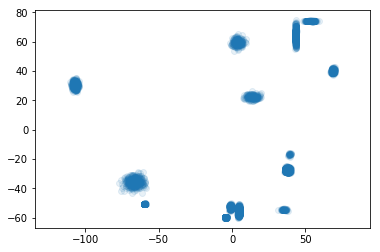

In [22]:
K = 15
locs,obs = mixtureGaussianDiagCovariance(D,K,N)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

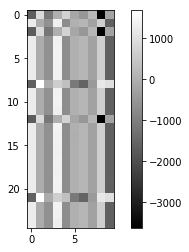

In [23]:
imN = 25
imD = 10
imK = 4
_,imobs = mixtureGaussianDiagCovariance(imD,imK,imN)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

In [24]:
def mixtureGaussianLowRankCovariance(D,K,N,rank=2):
    weights = pyro.sample('weights', dst.Dirichlet(0.5 * torch.ones(K)))
    locs = torch.empty((D,K))
    scales = torch.empty(rank,D,K)
    for k in range(K):
        loc,old_scale,obs = indepedentBivariate(D,N)
        locs[:,k] = loc
        cov_factor,obs = factorBivariate(loc,old_scale,D,rank,N)
        scales[:,:,k] = cov_factor
    locs *= 10
    obs = torch.empty((N,D))
    for n in range(N):
        assignment = pyro.sample('assignment', dst.Categorical(weights))
        scale = torch.matmul(scales[:,:,assignment],scales[:,:,assignment].transpose(0,1))#+torch.diag(old_scale)
        _,obs[n] = factorBivariate(locs[:,assignment],old_scale,D,K,1,cov_factor=scale)
    return locs,obs

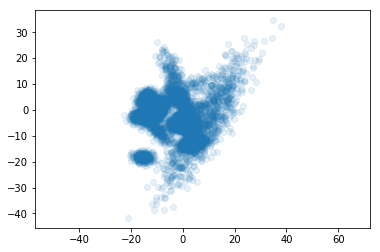

In [25]:
K = 15
locs,obs = mixtureGaussianLowRankCovariance(D,K,N,rank=2)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

In [26]:
imN = 25
imD = 10
imK = 3
_,imobs = mixtureGaussianLowRankCovariance(imD,imK,imN,rank=2)
plt.imshow(imobs,cmap='gray')#,aspect='auto')
plt.colorbar()

ValueError: cov_factor must be a batch of matrices with shape 10 x m

In [ ]:
K = 15
locs,obs = mixtureGaussianLowRankCovariance(K,N,rank=1)
print(locs)
print(coord_scale)
#print(torch.matmul(cov_factor,cov_factor.transpose(0,1))+torch.diag(scale))
plt.scatter(*obs.detach().numpy().T,alpha=.1)
plt.axis('equal');

In [ ]:
def projectedGaussian()

In [ ]:
def independentFactorModel():